# Differential gene expression analysis

Exercise for analysing gene expression changes between conditions.

* **Contact:** mate.balajti@unibas.ch

#### Differential gene expression analysis

One of the most common experiment types making use of RNA-Seq is a differential
gene expression analysis where gene expression levels across different
conditions (e.g., healthy vs disease) or compared to each other. This type of
experiment is often the basis for discovering genes that are relevant to a
given physiological or disease process. Following this relatively open-ended
discovery phase of a study, a list of genes with a strikingly different
expression pattern is often the basis for further, more detailed mechanistic
studies.

Required files:

* Control mate 1: `control.mate_1.fq.gz` (from Exercise 2)
* Control mate 2: `control.mate_2.fq.gz` (from Exercise 2)
* Treated mate 1: `treated.mate_1.fq.gz`
* Treated mate 2: `treated.mate_2.fq.gz`

Procedure:

* Create a table of counts for each gene (rows) and sample (columns)
* Analyze gene expression across different conditions based on such a count
  table

#### Exercise 3.1: Align the treatment reads to the reference genome (2 points)

Align the treated sample’s paired-end FASTQ files to the reference genome with `STAR` (similarly to Exercise 2) to produce a sorted, indexed `BAM` suitable for counting. 

Required files:

* Genome index (same one used for control in Exercise 2, created from `Mus_musculus.GRCm38.dna_rm.chr19.fa.gz`)
* Annotation GTF (same one used for control in Exercise 2, `Mus_musculus.GRCm38.88.chr19.gtf.gz`)
* Treated reads: `treated.mate_1.fq.gz`, `treated.mate_2.fq.gz`

Run `STAR` on the treated read pair using the same parameters and genome index you used for control.

> When using STAR, ensure `--outSAMtype BAM SortedByCoordinate` to get sorted BAM files as output; otherwise sort after alignment (using `samtools`)

In [ ]:
### Copy your command here
STAR \
  --runThreadN 4 \
  --genomeDir genome_index \
  --readFilesIn treated.mate_1.fq.gz treated.mate_2.fq.gz \
  --readFilesCommand zcat \
  --outFileNamePrefix treated_ \
  --outSAMtype BAM SortedByCoordinate


#### Exercise 3.2: Generate gene-level counts (3 points)

Summarize aligned reads to gene counts for control and treated using the GTF annotation. 
Choose a counting tool: **featureCounts** (recommended) or HTSeq-count.

featureCounts is part of the [subread](https://subread.sourceforge.net/) package (available through [bioconda](https://anaconda.org/bioconda/subread)). 
Follow [featureCounts\' manual](https://subread.sourceforge.net/SubreadUsersGuide.pdf#section.6.2) to summarize the aligned reads from the `BAM` files into a gene × sample count table (rows = genes, columns = control, treated).

Input files:
* Output from Exercise 2 and 3.1: `control.sorted.bam`, `treated.sorted.bam`
* Annotation GTF: `Mus_musculus.GRCm38.88.chr19.gtf.gz`


> Ensure both BAMs are coordinate-sorted and indexed before counting.

> Note that we're dealing with paired-end reads, therefore you have to count _fragments_ instead of reads (`-p` and `--countReadPairs` params are required).

In [ ]:
### Copy your command here
conda install -c bioconda subread

featureCounts \
  -T 4 \
  -p \
  -a Mus_musculus.GRCm38.88.chr19.gtf \
  -o control_treated_counts.txt \
  control.sorted.bam treated_Aligned.sortedByCoord.out.bam



#### Exercise 3.3: DESeq2 size-factor normalization (3 points)

Because we only have __1 control__ and __1 treated__ sample, we cannot estimate biological variance across replicates and therefore cannot perform reliable hypothesis testing. To keep the exercise scientifically grounded yet minimal, we will:

1. Implement DESeq2’s size-factor normalization
    - Compute the geometric mean per gene across samples (only genes with all non-zero counts)
    - For each sample, compute gene-wise ratios count / geometric mean
    - The size factor is the median of these ratios; divide raw counts by the size factor to obtain normalized counts

2. Rank genes by log2FC (and optionally by absolute log2FC)

3. Visualize the results
    - MA plot of (mean normalized count) vs (log2FC) for an effect-size view.

In a real analysis with adequate replication, these steps would be followed by __dispersion estimation__, __NB-GLM fitting__ under an appropriate design (accounting for covariates), __Wald/LRT__ testing with FDR control, and __LFC shrinkage__, plus thorough QC (PCA, dispersion plots, Cook’s/outlier checks). If you're interested, you can read more about DESeq2 [here](https://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html).



In [1]:
import pandas as pd
import numpy as np

# Read in your featureCounts output file into a pandas df
FEATURECOUNTS_TSV = "control_treated_counts.txt"  # path to your featureCounts output

fc = pd.read_csv(FEATURECOUNTS_TSV, sep="\t", comment="#").set_index("Geneid")


# Identify sample columns (featureCounts puts them at the end and they often end with .bam)
# Create the df "counts_df" with the sample columns and "Geneid" as the index
# You can change the name of the headers as well
counts_df = fc.iloc[:, -2:]
counts_df.columns = ['control', 'treated']


print(counts_df.head())

                    control  treated
Geneid                              
ENSMUSG00000100969        0        0
ENSMUSG00000093983        0        0
ENSMUSG00000024831      491      423
ENSMUSG00000024829      812      714
ENSMUSG00000099261        0        0


Implement the function `deseq_size_factors()` that takes one argument, a dataframe with two numerical columns (the counts from the samples) and returns a `pd.Series` of DESeq median-of-ratios size factors (indexed by the column names): compute per-gene geometric means, compute per-sample ratios `count/gm`, take the median ratio per sample as its size factor, and return the Series named `size_factor`.

> **Note:**
>
> If either samples have 0 count for a gene, the GM will be 0. Therefore, either filter out such genes, or when computing the median, ignore `NaN`'s (look it up in `numpy` how it's done).

In [ ]:
def deseq_size_factors(counts_df: pd.DataFrame) -> pd.Series:
    """
    DESeq median-of-ratios normalization:
      1) geometric mean (gm) per gene across samples
      2) for each sample, compute gene-wise ratios count / gm
      3) size factor = median of ratios over genes with gm > 0
    """
    # Filter out genes where any sample has a zero count
    counts_df_filtered = counts_df[(counts_df > 0).all(axis=1)]
    
    # 1
    geo_means = np.exp(np.log(counts_df_filtered).mean(axis=1))
    
    # 2
    ratios = counts_df_filtered.divide(geo_means, axis=0)
    
    # 3
    size_factors = ratios.median(axis=0)
    
    return size_factors





size_factors = deseq_size_factors(counts_df)
print("Calculated Size Factors:")
print(size_factors)


Calculated Size Factors:
control    1.096106
treated    0.912321
dtype: float64


Then, divide the counts by the computed size factors to get the normalized counts.

In [3]:
normalized_df = counts_df.divide(size_factors, axis=1)
print("\nNormalized Counts (first 5 rows):")
print(normalized_df.head())


Normalized Counts (first 5 rows):
                       control     treated
Geneid                                    
ENSMUSG00000100969    0.000000    0.000000
ENSMUSG00000093983    0.000000    0.000000
ENSMUSG00000024831  447.949289  463.652761
ENSMUSG00000024829  740.804119  782.619554
ENSMUSG00000099261    0.000000    0.000000


#### Exercise 3.4: Calculate fold change and explore (1 point)

Calculate the log2 fold change between the treated sample and the control sample from your normalized data. 

In [4]:
# Write your code here
# Add a pseudocount of 1 to avoid division by zero or log(0)
log2fc = np.log2((normalized_df['treated'] + 1) / (normalized_df['control'] + 1))
normalized_df['log2FC'] = log2fc

# Sort by log2FC to find the most up- and down-regulated genes
normalized_df_sorted = normalized_df.sort_values(by='log2FC', ascending=False)

print("Top 3 Upregulated Genes:")
print(normalized_df_sorted.head(3))

print("\nTop 3 Downregulated Genes:")
print(normalized_df_sorted.tail(3))



Top 3 Upregulated Genes:
                      control      treated    log2FC
Geneid                                              
ENSMUSG00000024669  14.597125  2291.957265  7.199785
ENSMUSG00000067577   0.000000   127.148275  7.001670
ENSMUSG00000045903   0.000000    25.210434  4.712069

Top 3 Downregulated Genes:
                      control   treated    log2FC
Geneid                                           
ENSMUSG00000025083   9.123203  0.000000 -3.339594
ENSMUSG00000050195  10.035524  0.000000 -3.464083
ENSMUSG00000025082  47.440658  2.192212 -3.923590


Which genes are up- and downregulated when the sample undergoes treatment? Write the 3 genes with the highest `log2FC` and 3 genes with the lowest `log2FC`. Look up the gene names that belong to these 6 Gene ID's. What are their functions?

> **Hint:** 
>
> You could make use of the [Ensembl](https://www.ensembl.org/index.html) or [NCBI](https://www.ncbi.nlm.nih.gov/) databases. 

ENSMUSG00000024669 == Mouse Gene: Cd5
Cd5 encodes a cell surface glycoprotein expressed on T cells and a subset of B cells. It plays a role in regulating T cell activation and survival.

ENSMUSG00000067577 == Mouse Gene: RIKEN cDNA A430093F15 gene
didn't found out the function, my research led to:  no experimental evidence supporting its role in molecular function, biological processes, or cellular components

ENSMUSG00000045903 == Mouse Gene: Npas4 (neuronal PAS domain protein 4)
Npas4 is a transcitption factor that regulates the developement and plasticity of neurons, particularly in response to neuronal activity.

ENSMUSG00000025083 == Mouse Gene: Afap1l2 
Afap1l2 encodes actin filament-associated protein 1-like 2, which is involved in actin cytoskeleton organization and may play a role in cell signaling and movement.

ENSMUSG00000050195 == Mouse Gene: Scd4
Scd4 encodes stearoyl-CoA desaturase 4, an enzyme involved in the biosynthesis of unsaturated fatty acids, which are important for membrane fluidity and function

ENSMUSG00000025082 == Mouse Gene: Vwa2 
Vwa2 encodes a protein containing von Willebrand factor A domains, which are involved in protein-protein interactions and may play a role in cell adhesion.


#### Exercise 3.5: Visualize results (1 point)

Use the `matplotlib` or [`seaborn`](https://seaborn.pydata.org/) Python package to create an MA-plot showing your results. The plot shows the average expression on the x-axis and the log2FC on the y. It should look something like this:

![MA-plot](ma_plot.png)

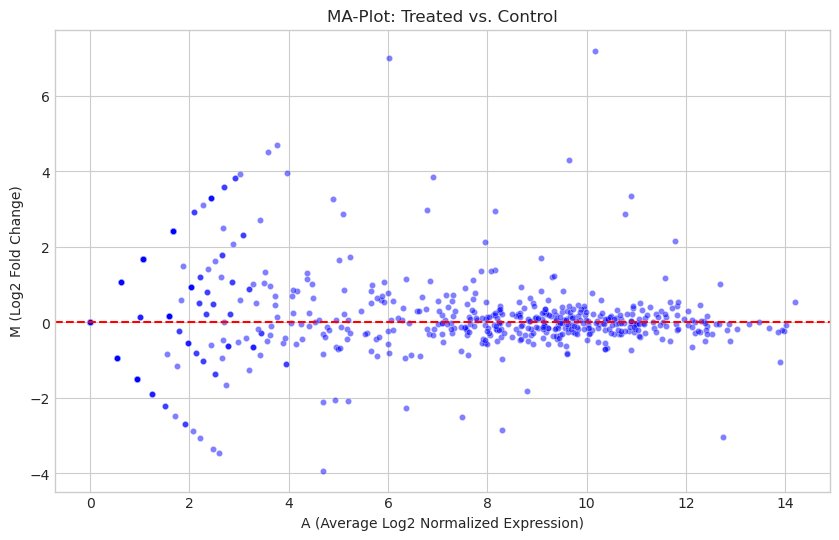

In [24]:
#conda install -c conda-forge matplotlib seaborn

import matplotlib.pyplot as plt
import seaborn as sns

normalized_df['A_mean_log2'] = np.log2(normalized_df[['control', 'treated']].mean(axis=1) + 1)

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=normalized_df,
    x='A_mean_log2',
    y='log2FC',
    alpha=0.5,
    s=20,
    color='blue'
)

plt.axhline(0, color='red', linestyle='--')

plt.xlabel("A (Average Log2 Normalized Expression)")
plt.ylabel("M (Log2 Fold Change)")
plt.title("MA-Plot: Treated vs. Control")
plt.grid(True)

plt.show()